# Learning Device Models with RNNs

This notebook details some example code for running and reproducing the results given in the paper:

> "Learning Device Models with Recurrent Neural Networks", Clemens, J. IJCNN 2018  
> \[ paper | slides | [arXiv](https://arxiv.org/abs/1805.07869) | [juptyer](https://gitlab.com/clemej/neurodev-models/tree/master/ijcnn18/ijcnn18-demo.ipynb) | bibtex \]

Abstract:
    
> Recurrent neural networks (RNNs) are powerful constructs capable of modeling 
> complex systems, up to and including Turing Machines. However, learning such complex
> models from finite training sets can be difficult. In this paper we empirically show 
> that RNNs can learn models of computer peripheral devices through input and output 
> state observation. This enables automated development of functional software-only
> models of hardware devices. Such models are applicable to any number of tasks, including 
> device validation, driver development, code de-obfuscation, and reverse engineering. 
> We show that the same RNN structure successfully models six different devices
> from simple test circuits up to a 16550 UART serial port, and verify that these models 
> are capable of producing equivalent output to real hardware.
    
This is not the exact code used, but is as close as possible to that used in the paper. It has a few new features and enhancements that should not effect the experiments presented.

## Prerequisits

The experiments in the paper use Python 3, Keras (v2) and TensorFlow as the backend, although the backend should not matter.  In fact, early experiments used Theano. The code also makes heavy use of numpy arrays.  Some visualizations are generated using matplotlib.  

The author kept track of experiments each experiment using sacred, but that is not necessary 
understand or duplicate the work.  However, is it a good project and it (or something like it) is very useful. 

The minimal list of python 3 dependencies to run the examples in this notebook is:

* numpy
* matplotlib
* keras
* tensorflow (or tensorflow-gpu)

## Dataset

The simple machines used in this paper are written in python3 and available in the 
source code repository that hosts this notebook.  The authoritative location is 

[https://gitlab.com/clemej/neurodev-models](https://gitlab.com/clemej/neurodev-models) 

Altough I intend to make this code available on IEEE Code Ocean as well.

Since the dataset is randomly generated, it is not useful for me to provide the exact same
dataset used in the paper. Instead, I encourage anyone interested to create their own 
randomly-generatd dataset and use that to train their networks.  The results should be 
comparable. 

The 6 machine types supported in the paper are:

* `EightBitMachine`
* `SingleDirectMachine`
* `SingleInvertMachine`
* `SimpleXORMachine`
* `ParityMachine`
* `SerialPortMachine`

> The updated code also supports a `VGATextMachine`, for future research.

These machine names are case sensitive and used throughout the code. The inputs 
and outputs of each machine are encoded into binary vectors (1 or 0) encoded as 
floating point vectors.  For the exact encodings, please see the paper. 

> One enhancement to the encoding not listed in the paper is that the serial port output
> encoding now has optional support for encoding the baudrate as a decimal, hexidecimal, 
> or binary as well as float as was used in the paper.  However, there's not an easy way 
> to set this flag without modifying the dataset_generator function in serialmachine.py

The code expects the dataset to be in an HDF5 file, with groups set as te name of 
the machine to test, and the `datasets` (in HDF5 terms) to be named:

* `Xt` : training inputs
* `Yt` : training outputs
* `Xv` : validation inputs
* `Yv` : validation outputs
* `Xs` : evaluation inputs
* `Ys` : evaluation outputs

To generate your own training sets, clone the above repostory:

    $ git clone https://gitlab.com/clemej/neurodev-models && cd neurodev-models

`generate_training_data.py` will generate the dataset in the properly formatted HDF5 file. The command takes the following arguments: 

    generate_training_data.py <output> <seqlen> <trainsize> <valsize> <evalsize> <machine(s)>
    
So, to generate a dataset comparable to the dataset used in the paper, use the command:

    $ python3 ./generate_training_data.py dataset.htf5 1024 4096 1024 128 EightBitMachine SingleDirectMachine SingleInvertMachine SimpleXORMachine ParityMachine SerialPortMachine
    
This takes approximately 20 minutes on my laptop from 2015.  

The rest of this notebook assumes the dataset is available as a file in the current directory named `dataset.hdf5`. 

## Experiments

First, we need to load Keras and several libraries needed to create, train, and evaluate these networks:

In [1]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, GRU, LSTM, SimpleRNN, Dropout, CuDNNGRU, CuDNNLSTM, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, CSVLogger, LambdaCallback, TerminateOnNaN
import numpy as np
import h5py
import os
import tempfile
import shutil
import math

/home/john/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next we can define a function to create the network of the right shape and size to train.  Note that, in Keras, the first GRU layer is really a combined input and GRU layer.  This version is a slightly enhanced version of the original function that includes an optional dropout parameter.  Note: We use a custom scaling actication at the last layer to scale linearly from tanh (-1,1) to out desired range of (0,1) inclusive.  This means that any models saved must define this function again when loading. See Keras documentation for details.

In [2]:
def scaletanh(x):
        return (x+1.0)/2.0

def build_model(n_in, n_out, seqlen, ntype='gru', metrics=[], nhidden=0, 
                                actfunc='tanh', opt='nadam', loss='msle',
                                dropout_pct=0.0, r_actfunc = 'hard_sigmoid', 
                                use_cuda=False):

        hidden_widths = int((max(n_in, n_out)+1) * (1.0 + dropout_pct)) + 1

        if use_cuda == True:
                if ntype=='gru':
                        ntype='cugru'
                if ntype == 'lstm':
                        ntype='culstm'
                
        ntypefunc = {'srnn': SimpleRNN, 'lstm': LSTM, 'gru': GRU, 'cugru': CuDNNGRU, 'culstm': CuDNNLSTM }[ntype]

        model = Sequential()
        model.add(ntypefunc(n_in, input_shape=(seqlen, n_in),
                                activation=actfunc,
                                return_sequences=True))
        for i in range(nhidden-1):
                model.add(ntypefunc(hidden_widths, 
                                return_sequences=True, 
                                activation=actfunc,
                                dropout=dropout_pct,
                                recurrent_dropout=dropout_pct,
                                recurrent_activation=r_actfunc))
        model.add(TimeDistributed(Dense(n_out, activation=actfunc)))
        model.add(Activation(scaletanh))
        model.compile(loss=loss, optimizer=opt, metrics=metrics)
        return model

Next, we define a few early stopping functions to break training when certain criteria are met.  The first simple checks for the presence of a file to gracefully end training at the end of the current epoch: 

In [3]:
class EarlyStopInterrupt(Callback):
        def on_epoch_end(self, epoch, logs={}):
                if os.path.exists("STOPNOW"):
                        print("\nFound stop file, exiting\n")
                        self.model.stop_training = True

..and a second function which stops when the valication loss drops below 0.1% for more than 20 epochs.

In [4]:
class EarlyStopGood(Callback):
        def __init__(self, patience=20, threshold=0.001):
                super(Callback, self).__init__()
                self.patience = patience
                self.threshold = threshold
                self.count = 0
                
        def on_epoch_end(self, epoch, logs={}):
                if logs.get('val_loss', None):
                        vloss = logs['val_loss']
                        if vloss < self.threshold:
                                if self.count >= self.patience:
                                        print("\nEarlyStopping GOOD! epoch %d\n" % (epoch,))
                                        self.model.stop_training = True
                                        return
                                self.count += 1
                                return
                self.count = 0

And finally, a main driver function for training and capturing the information from this network:

In [5]:
def experiment(machine, ntype, nhidden, batch_size, epochs, dataset_name='dataset.hdf5'):
    
    print("Using dataset " + dataset_name)
    dataset = h5py.File(dataset_name, 'r')
    
    print("Using machine " + machine)
    
    outdir = tempfile.mkdtemp(prefix='exp')
    print("Using working directory " + outdir)
    
    Xt = dataset['%s/Xt' % (machine)]
    Yt = dataset['%s/Yt' % (machine)]
    Xv = dataset['%s/Xv' % (machine)]
    Yv = dataset['%s/Yv' % (machine)]
    Xs = dataset['%s/Xs' % (machine)]
    Ys = dataset['%s/Ys' % (machine)]
    
    expname = "%s-%s-%d" % (machine, ntype, nhidden)
    print("Starting experiment " + expname)
    
    nan = TerminateOnNaN()
    esg = EarlyStopGood()
    esi = EarlyStopInterrupt()
    # uncomment to and add to list below to log loss/epoch to csv
    csv = CSVLogger('%s/%s-hist.csv' % (outdir,expname))
    mc = ModelCheckpoint(
                filepath='%s/%s-{epoch:04d}-{val_loss:.5f}.model' % (outdir,expname), 
                                                                            period=16)
    mcl = ModelCheckpoint(filepath='%s/%s-latest.model' % (outdir, expname), period=1)


    model = build_model(Xt.shape[2], Yt.shape[2], Xt.shape[1], nhidden=nhidden)
    model.summary()
    
    hist = model.fit(Xt, Yt, verbose=2, batch_size=batch_size, 
                        epochs=epochs, validation_data=(Xv,Yv), shuffle='batch', 
                        callbacks=[mc, esg, nan, esi, mcl, csv])

    print("Saving last model %s.model" % (expname,))
    model.save('%s/%s-final.model' % (outdir,expname))

    print("Evaluating model")
    eval_loss = model.evaluate(Xs, Ys, verbose=2)
    print("Eval loss: " + str(eval_loss))

    return model, hist.history['loss'], hist.history['val_loss'], eval_loss


## Example

Using the above code, we can generate all of the examples used in the paper by tweaking the parameters.  An example is given below, recreating the hyperparamters used in paper. 

In [6]:
m, l, vl, el = experiment('EightBitMachine','gru',4,128,4096)

Using dataset dataset.hdf5
Using machine EightBitMachine
Using working directory /tmp/expm9tq9lxb
Starting experiment EightBitMachine-gru-4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1024, 9)           513       
_________________________________________________________________
gru_2 (GRU)                  (None, 1024, 11)          693       
_________________________________________________________________
gru_3 (GRU)                  (None, 1024, 11)          759       
_________________________________________________________________
gru_4 (GRU)                  (None, 1024, 11)          759       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1024, 8)           96        
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 8)           0         
To

Eval loss: 0.00013028853936702944


In [7]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1024, 9)           513       
_________________________________________________________________
gru_2 (GRU)                  (None, 1024, 11)          693       
_________________________________________________________________
gru_3 (GRU)                  (None, 1024, 11)          759       
_________________________________________________________________
gru_4 (GRU)                  (None, 1024, 11)          759       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1024, 8)           96        
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 8)           0         
Total params: 2,820
Trainable params: 2,820
Non-trainable params: 0
_________________________________________________________________


We can now do things like plot the validation loss (example below) or any other analysis you wish

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

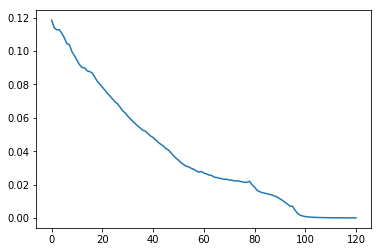

In [9]:
plt.plot(vl)

Or generate the heatmap plots similar to those shown in the paper. 

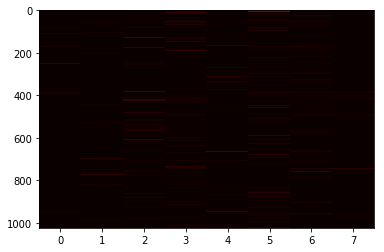

In [10]:
dataset = h5py.File('dataset.hdf5', 'r')
X = dataset['EightBitMachine/Xs']
Y = dataset['EightBitMachine/Ys']

y_pred = m.predict(X)
diff = np.abs(y_pred[0] - Y[0])
plt.imshow(diff, cmap="hot", 
               vmin=0., vmax=1, aspect='auto',  
               interpolation='nearest')

In [11]:
plt.imshow(diff, cmap="hot", 
               vmin=0., vmax=0.2, aspect='auto',  
               interpolation='nearest')

## Conclusions

With the above code, it is easy to see how to recreate the experiments used in the IJCNN paper. If you have any questions or concerns, please contact the corresponding author at clemej1_at_umbc.edu.